In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load` with `weights_only=False`")
warnings.filterwarnings("ignore", category=UserWarning, message="The PyTorch API of nested tensors is in prototype stage and will change in the near future.")

%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0,"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre")
            
            
from notebook_and_scripts.SMILES_fragmenting.build_dataset_specific_FP.find_frags import  get_bitInfos_for_each_atom_idx
import io
from PIL import Image
from math import sqrt
from rdkit.Chem.Draw import SimilarityMaps

import torch
from rdkit import Chem
from rdkit.Chem import Draw

from PIL import Image
import base64


from datasets.dataset_utils import fp_loader_configer

fp_loader_configer.select_version("Hash_Entropy")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
choosing Hash_Entropy_FP_loader


In [3]:

def compute_cos_sim(fp1, fp2):
    fp1 = fp1.float()
    fp2 = fp2.float()
    
    return ((fp1 @ fp2).item() / (torch.norm(fp1) * torch.norm(fp2))).item()


In [7]:
from inference.inference_utils import choose_model 

hparams, model, test_loader = choose_model("optional", return_test_loader=True)


loading model from:  /root/gurusmart/MorganFP_prediction/reproduce_previous_works/entropy_on_hashes/flexible_models_jittering_flexible_MW_flexible_normal_hsqc/r0_r6_trial_1/checkpoints/epoch=95-step=21696.ckpt


Initialized SignCoordinateEncoder[784] with dims [365, 365, 54] and 2 positional encoders. 54 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
finish entropy list
Hash_Entropy_FP_loader is setup, out_dim=16384, max_radius=6


In [42]:
def show_retrieved_mol_with_highlighted_frags(predicted_FP, retrieval_smiles, need_to_clean_H=False, img_size=400, ): 
    '''
    used in db-specific FP
    This functions visualizes the retrieved molecule with the predicted fragments highlighted
    '''
    def show_png(data):
        
        bio = io.BytesIO(data)
        img = Image.open(bio)
        return img
    fp_loader = fp_loader_configer.fp_loader
    
    # retrieval_FP = fp_loader.build_mfp_for_new_SMILES(retrieval_smiles)
    
    # Step 1: Create molecule and hydrogenated copy
    retrieval_mol = Chem.MolFromSmiles(retrieval_smiles)
    
    atom_to_bit_infos,_ = get_bitInfos_for_each_atom_idx(retrieval_smiles)
   
    retrieval_FP = fp_loader.build_mfp_from_bitInfo(atom_to_bit_infos)
    baseSimilarity = compute_cos_sim(retrieval_FP, predicted_FP.cpu())
    # print("base similarity: ", baseSimilarity)
    weights = [
        baseSimilarity - compute_cos_sim(predicted_FP.cpu(), fp_loader.build_mfp_from_bitInfo(atom_to_bit_infos, [atomId]))
        for atomId in range(retrieval_mol.GetNumAtoms())
    ] 
    

    weights, max_weight = SimilarityMaps.GetStandardizedWeights(weights)
    # Step 5: Draw similarity map on molecule without hydrogens
    d = Draw.MolDraw2DCairo(img_size, img_size)
    SimilarityMaps.GetSimilarityMapFromWeights(retrieval_mol, weights, draw2d=d)
    
    d.FinishDrawing()
    img = (show_png(d.GetDrawingText()))
    
    # img.show()
    return img

In [30]:
atom_to_bit_infos,_ = get_bitInfos_for_each_atom_idx(new_compoundB_smiles)

In [36]:
atom_to_bit_infos[13]

[(136820377, 'C', 'cCC(NC)C(N)=O', 2),
 (795904041, 'C', 'cc(c)CC(NC(C)=O)C(=O)NC', 3),
 (865969245, 'C', 'C=C(C)NC(=O)C(Cc(cc)cc)NC(=O)C(C)N', 4),
 (1545388477,
  'C',
  'C/C=C(\\NC(=O)C(Cc1ccccc1)NC(=O)C(NC(C)=O)C(C)CC)C(=O)NC',
  6),
 (1666581173,
  'C',
  'C/C=C(\\NC(=O)C(Cc1ccccc1)NC(=O)C(NC(=O)C(NC(C)=O)C(C)CC)C(C)CC)C(=O)NC(C(=O)OC)C(C)C',
  9),
 (2045023652,
  'C',
  'C/C=C1\\NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)CC)NC(=O)C(C(C)CC)NC(=O)C(N)C(C)OC(=O)C(C(C)C)NC1=O',
  10),
 (2638642350,
  'C',
  'C/C=C(\\NC(=O)C(Cc1ccccc1)NC(=O)C(NC(=O)C(C)N)C(C)CC)C(=O)NC(C)C',
  7),
 (2976033787, 'C', '', 0),
 (3791102067, 'C', 'CC(C)N', 1),
 (3816238962,
  'C',
  'C/C=C(\\NC(=O)C(Cc1ccccc1)NC(=O)C(NC(=O)C(NC)C(C)C)C(C)CC)C(=O)NC(C(=O)O)C(C)C',
  8),
 (4048693230, 'C', 'C/C=C(\\NC(=O)C(Cc1ccccc1)NC(=O)C(NC)C(C)C)C(N)=O', 5)]

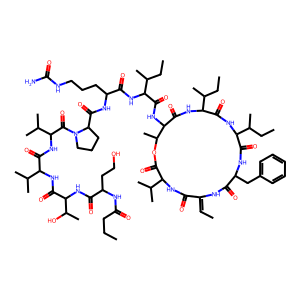

In [8]:
new_compoundB_smiles = "CCC(C1C(NC(C(C)CC)C(NC(CC2=CC=CC=C2)C(N/C(C(NC(C(C)C)C(OC(C)C(NC(C(NC(C(NC(C3CCCN3C(C(NC(C(NC(C(NC(C(NC(CCC)=O)CCO)=O)C(O)C)=O)C(C)C)=O)C(C)C)=O)=O)CCCNC(N)=O)=O)C(CC)C)=O)C(N1)=O)=O)=O)=C\C)=O)=O)=O)C"
Draw.MolToImage(Chem.MolFromSmiles(new_compoundB_smiles)).show()


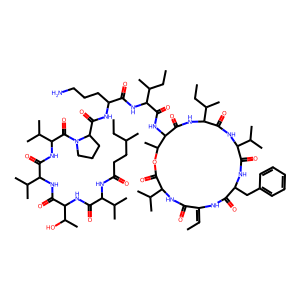

In [9]:
fp_loader = fp_loader_configer.fp_loader
newCompoundB_FP = fp_loader.build_mfp_for_new_SMILES(new_compoundB_smiles)

retrieval_smiles = "CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCC(C)CC)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O"
Draw.MolToImage(Chem.MolFromSmiles(retrieval_smiles)).show()


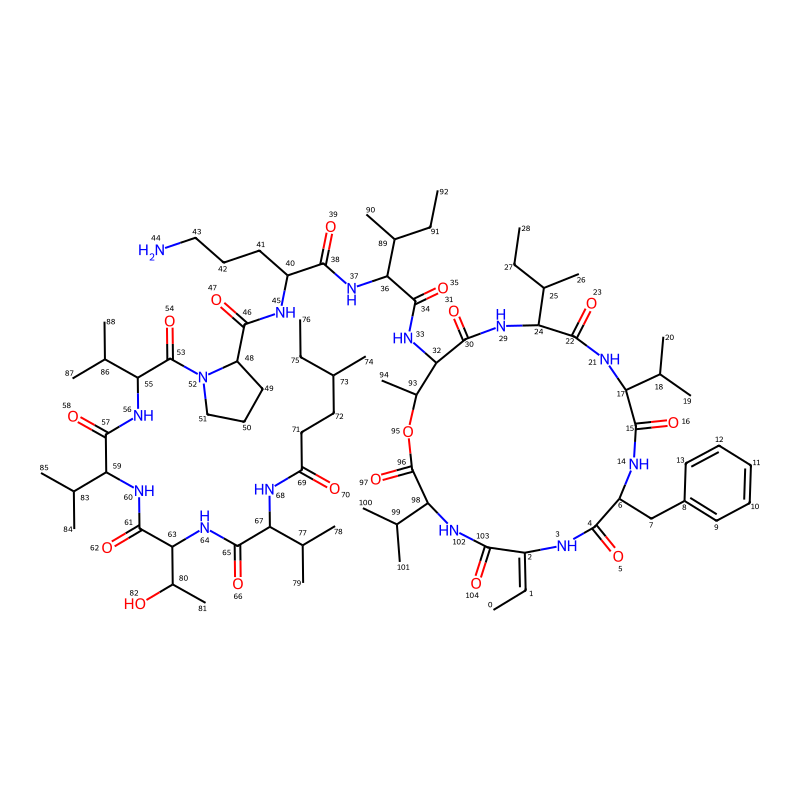

In [10]:
m = Chem.MolFromSmiles(retrieval_smiles)
for atom in m.GetAtoms():
    atom.SetProp("atomNote", str(atom.GetIdx()))
img = Draw.MolToImage(m, size=(800, 800))
img.show()

In [11]:
retrieval_mol = Chem.MolFromSmiles(retrieval_smiles)
    
atom_to_bit_infos,_ = get_bitInfos_for_each_atom_idx(retrieval_smiles)

retrieval_FP = fp_loader.build_mfp_from_bitInfo(atom_to_bit_infos)
baseSimilarity = compute_cos_sim(retrieval_FP, newCompoundB_FP.cpu())
print("base similarity: ", baseSimilarity)


base similarity:  0.9006820321083069


In [41]:
# weights = [
#     baseSimilarity - compute_cos_sim(newCompoundB_FP.cpu(), fp_loader.build_mfp_from_bitInfo(get_bitInfos_for_each_atom_idx(retrieval_smiles, ignoreAtoms=[atomId])[0]))
#     for atomId in range(retrieval_mol.GetNumAtoms())
# ] 
compute_cos_sim(newCompoundB_FP.cpu(), fp_loader.build_mfp_from_bitInfo(get_bitInfos_for_each_atom_idx(retrieval_smiles)[0] , ignoreAtoms=[99]))

[99]
setting to 0 (895910141, 'C', 'CC(C)C', 1) True
setting to 0 (1029490013, 'C', 'CC(C)C(C)N', 2) True
setting to 0 (2245273601, 'C', '', 0) True


0.8897565007209778

[]
[0]
setting to 0 (2246728737, 'C', '', 0) True
setting to 0 (3545353036, 'C', 'CC', 1) True
[1]
setting to 0 (2246703798, 'C', '', 0) True
setting to 0 (2547188886, 'C', 'CC=C(C)N', 2) True
setting to 0 (3979703018, 'C', 'C=CC', 1) True
[2]
setting to 0 (1009026067, 'C', 'CC=C(NC(C)=O)C(=O)NC', 3) False
setting to 0 (1613640329, 'C', 'CC=C(NC(=O)C(Cc1ccccc1)NC(=O)C(NC)C(C)C)C(=O)NC(C(=O)OC(C)C(C)N)C(C)C', 8) False
setting to 0 (2691009069, 'C', 'cc(c)CC(NC(C)=O)C(=O)NC(=CC)C(=O)NC(C(=O)OC)C(C)C', 6) False
setting to 0 (2947009581, 'C', 'CC=C(NC)C(N)=O', 2) True
setting to 0 (3118423884, 'C', 'CC=C(NC(=O)C(C)N)C(=O)NC(C)C', 4) False
setting to 0 (3217380708, 'C', '', 0) True
setting to 0 (3563278578, 'C', 'CC=C(NC(=O)C(Cc)NC)C(=O)NC(C(=O)O)C(C)C', 5) False
setting to 0 (4062657848, 'C', 'CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C)NC(=O)C(NC(C)=O)C(C)OC(=O)C(C(C)C)NC1=O', 10) False
setting to 0 (4102081611, 'C', 'CC=C(NC(=O)C(Cc1ccccc1)NC(=O)C(NC(C)=O)C(C)C)C(=O)NC(C(=O)OC(C)C(NC)

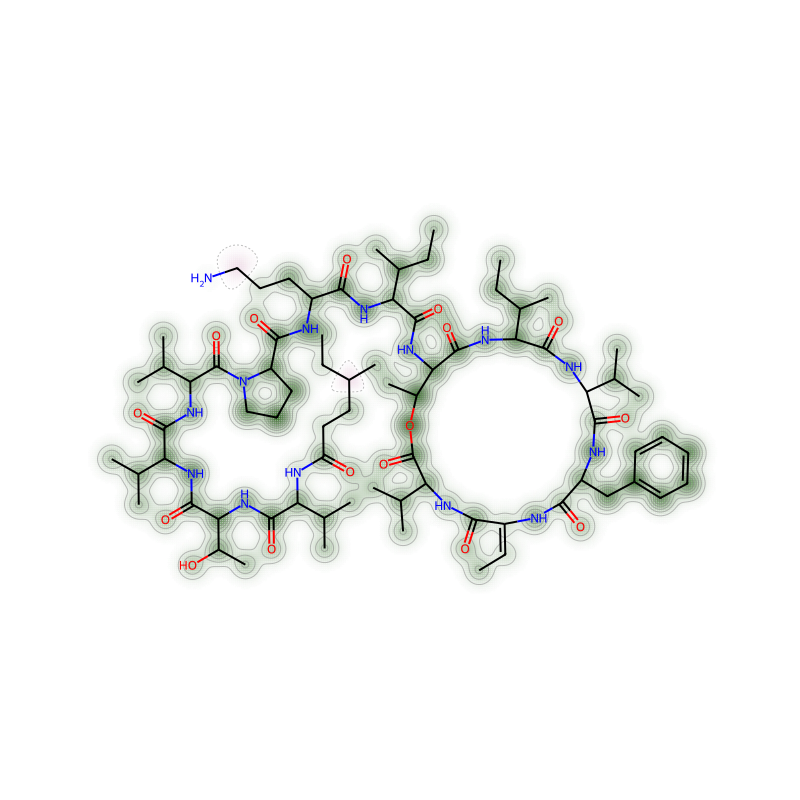

In [43]:
show_retrieved_mol_with_highlighted_frags(predicted_FP = newCompoundB_FP, retrieval_smiles = retrieval_smiles, img_size=800)

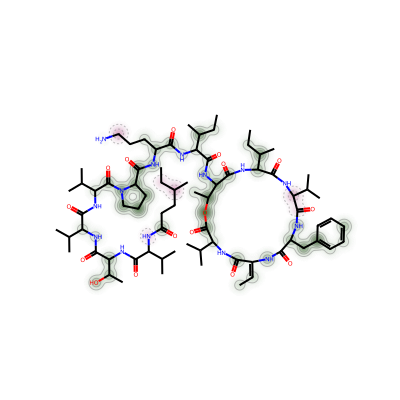

In [ ]:
show_retrieved_mol_with_highlighted_frags_fixed(predicted_FP = newCompoundB_FP, retrieval_smiles = retrieval_smiles,)

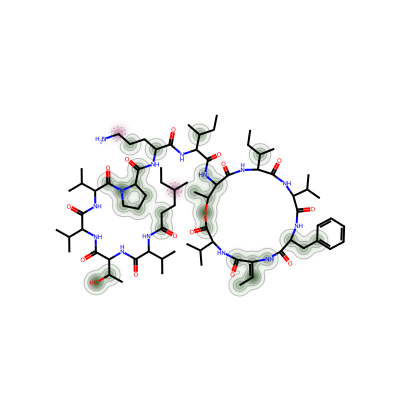

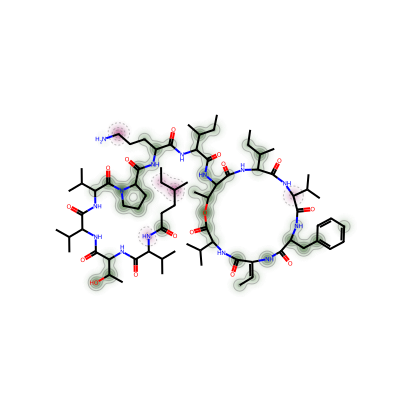

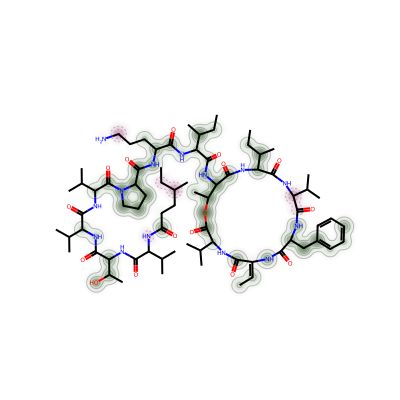

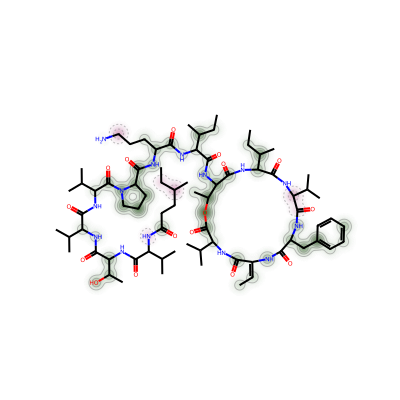

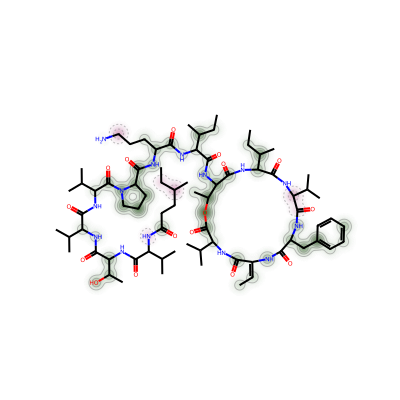

In [ ]:
for filter_r in [1,2,3,4,5]:
    show_retrieved_mol_with_highlighted_frags(predicted_FP = newCompoundB_FP, retrieval_smiles = retrieval_smiles, filter_r_in_similar_map = filter_r).show()

[03:11:58] DEPRECATION WARNING: please use MorganGenerator
[03:11:58] DEPRECATION WARNING: please use MorganGenerator


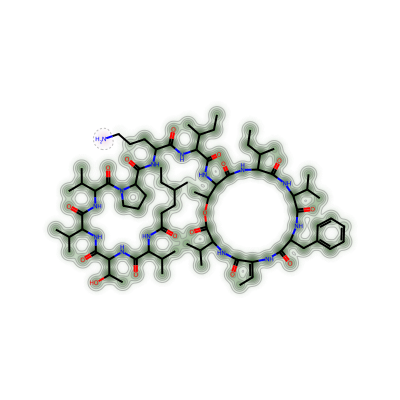

[03:11:58] DEPRECATION WARNING: please use MorganGenerator
[03:11:58] DEPRECATION WARNING: please use MorganGenerator


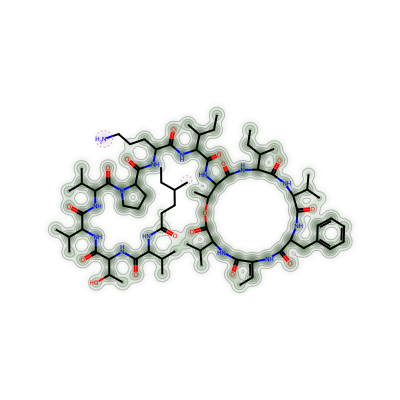

[03:11:59] DEPRECATION WARNING: please use MorganGenerator
[03:11:59] DEPRECATION WARNING: please use MorganGenerator


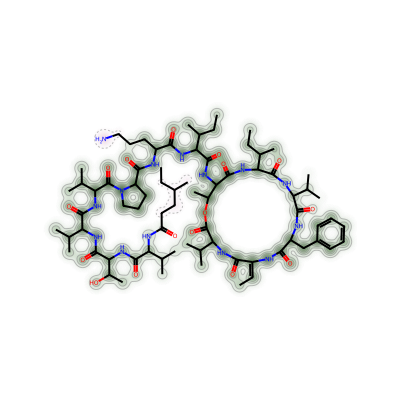

[03:11:59] DEPRECATION WARNING: please use MorganGenerator
[03:11:59] DEPRECATION WARNING: please use MorganGenerator


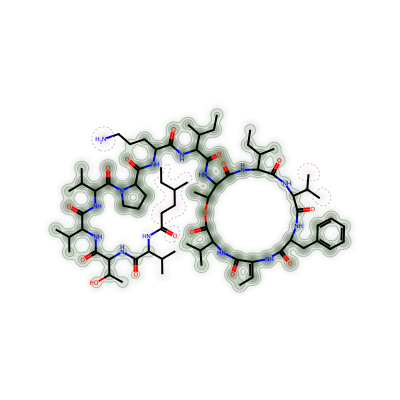

[03:12:00] DEPRECATION WARNING: please use MorganGenerator
[03:12:00] DEPRECATION WARNING: please use MorganGenerator


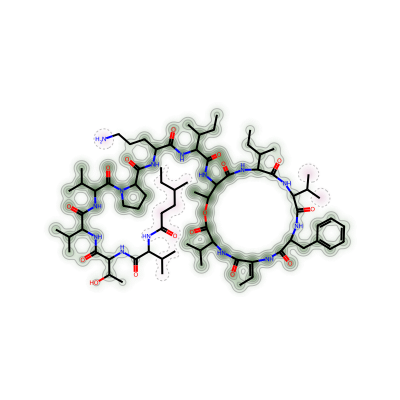

In [ ]:
def show_png(data):
    bio = io.BytesIO(data)
    img = Image.open(bio)
    return img
d = Draw.MolDraw2DCairo(400, 400)
from rdkit.Chem.Draw import SimilarityMaps

for radius in [1,2,3,4,5]:

    _, maxWeight = SimilarityMaps.GetSimilarityMapForFingerprint( Chem.MolFromSmiles(new_compoundB_smiles),  Chem.MolFromSmiles(retrieval_smiles), 
                                            lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=radius, fpType='bv'), 
                                            draw2d=d)
    d.FinishDrawing()
    x = show_png(d.GetDrawingText())
    display(x)